In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-01 01:41:51.238270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 01:41:51.298712: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-01 01:41:51.711203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_046


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes
0,4995,5039.0,5051.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5
1,10928,10895.0,10907.5,038441c925bb,0.754868,wakeup,33.655094,37.0,2337.5
2,20288,20375.0,20387.5,038441c925bb,0.630360,onset,-86.351067,-131.0,2937.5
3,27432,27455.0,27467.5,038441c925bb,0.880441,wakeup,-22.161205,37.0,2337.5
4,39989,40007.0,40019.5,038441c925bb,0.879920,onset,-17.894793,-11.0,297.5


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [3]:
# 周辺に予測を撒く
dfs = []
for level, diff in enumerate([0, -5, 5, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["key_step"] += CFG["feature"]["agg_freq"] * diff
    tmp["sub_step_before_modify"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub.head()

,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4275,4319.0,4331.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,5
1,4635,4679.0,4691.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,3
2,4875,4919.0,4931.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,1
3,4995,5039.0,5051.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,0
4,5115,5159.0,5171.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,2


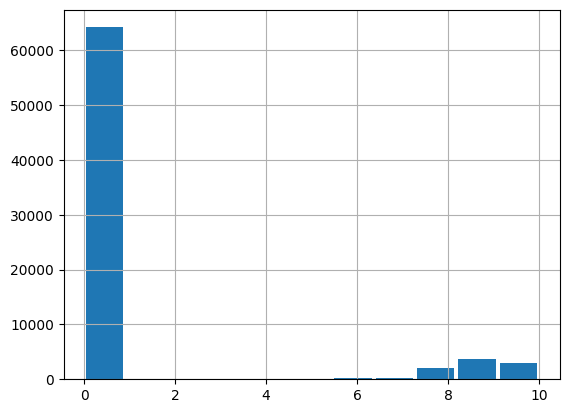

series_id                 5331307
step                      5331307
oof_stage2                5331307
minutes                    877741
target                      73491
sub_step                    73491
key_step                    73491
sub_step_before_modify      73491
event                       73491
level                       73491
score                       73433
oof_regressor               73491
dtype: int64
3.1712430470020356


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [5]:
# スコアの理論値(targetを完璧に当てれた場合)
ideal_sub = sub.copy()
ideal_sub["score"] = ideal_sub["target"]
ideal_sub["step"] = ideal_sub["sub_step"]

labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, ideal_sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.8557


event   tolerance
onset   12           0.295763
        36           0.671259
        60           0.885201
        90           0.914214
        120          0.938844
        150          0.945523
        180          0.953663
        240          0.956377
        300          0.959090
        360          0.963682
wakeup  12           0.306633
        36           0.687109
        60           0.897580
        90           0.929287
        120          0.957447
        150          0.964330
        180          0.969545
        240          0.971005
        300          0.973091
        360          0.974552
dtype: float64

In [17]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.8562023995826813


event   threshold
onset   12           0.295763
        36           0.671676
        60           0.885828
        90           0.914840
        120          0.939470
        150          0.946149
        180          0.954289
        240          0.957003
        300          0.959716
        360          0.964517
wakeup  12           0.307050
        36           0.687526
        60           0.897997
        90           0.929704
        120          0.957864
        150          0.964748
        180          0.969962
        240          0.971423
        300          0.973509
        360          0.974969
Name: target, dtype: float64

In [6]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:24<00:00,  1.36it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,0.0,4275.0,4331.5,4319.0,onset,5.0,...,0.0,0.960272,-0.002529,0.737917,0.0,0.998246,-0.000057,0.927509,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,0.0,4635.0,4691.5,4679.0,onset,3.0,...,0.0,0.959926,-0.003268,0.719422,0.0,0.998064,-0.000062,0.921510,0.0,2
2,038441c925bb,4931.5,0.978979,1257.5,0.0,4875.0,4931.5,4919.0,onset,1.0,...,0.0,0.956779,-0.003403,0.711094,0.0,0.997368,-0.000110,0.908672,0.0,2
3,038441c925bb,5051.5,0.120360,1857.5,10.0,4995.0,5051.5,5039.0,onset,0.0,...,0.0,0.955621,-0.004250,0.706929,0.0,0.996829,-0.000130,0.899326,0.0,2
4,038441c925bb,5171.5,0.151996,2457.5,0.0,5115.0,5171.5,5159.0,onset,2.0,...,0.0,0.955607,-0.003614,0.704544,0.0,0.995787,-0.000106,0.888587,0.0,2


(73491, 1390)

In [7]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:3.02774
[100]	eval-rmse:2.06029
[200]	eval-rmse:1.87259
[300]	eval-rmse:1.84080
[400]	eval-rmse:1.83447
[500]	eval-rmse:1.83205
[600]	eval-rmse:1.83145
[700]	eval-rmse:1.83131
[800]	eval-rmse:1.83114
[900]	eval-rmse:1.83080
[1000]	eval-rmse:1.83017
[1100]	eval-rmse:1.82996
[1200]	eval-rmse:1.83007
[1218]	eval-rmse:1.82995


 20%|██        | 1/5 [00:22<01:28, 22.07s/it]

== fold 1 ==
[0]	eval-rmse:3.03894
[100]	eval-rmse:2.08891
[200]	eval-rmse:1.89843
[300]	eval-rmse:1.85875
[400]	eval-rmse:1.84831
[500]	eval-rmse:1.84468
[600]	eval-rmse:1.84272
[700]	eval-rmse:1.84200
[800]	eval-rmse:1.84181
[900]	eval-rmse:1.84131
[1000]	eval-rmse:1.84076
[1073]	eval-rmse:1.84079


 40%|████      | 2/5 [00:41<01:01, 20.44s/it]

== fold 2 ==
[0]	eval-rmse:3.01912
[100]	eval-rmse:2.12075
[200]	eval-rmse:1.95232
[300]	eval-rmse:1.92145
[400]	eval-rmse:1.91460
[500]	eval-rmse:1.91089
[600]	eval-rmse:1.90866
[700]	eval-rmse:1.90799
[800]	eval-rmse:1.90684
[900]	eval-rmse:1.90669
[931]	eval-rmse:1.90658


 60%|██████    | 3/5 [00:57<00:37, 18.67s/it]

== fold 3 ==
[0]	eval-rmse:3.01853
[100]	eval-rmse:2.08125
[200]	eval-rmse:1.91169
[300]	eval-rmse:1.88542
[400]	eval-rmse:1.88032
[500]	eval-rmse:1.88082
[510]	eval-rmse:1.88092


 80%|████████  | 4/5 [01:08<00:15, 15.54s/it]

== fold 4 ==
[0]	eval-rmse:2.96959
[100]	eval-rmse:2.06832
[200]	eval-rmse:1.92193
[300]	eval-rmse:1.90531
[400]	eval-rmse:1.90603
[423]	eval-rmse:1.90631


100%|██████████| 5/5 [01:17<00:00, 15.42s/it]


In [8]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.7278


event   tolerance
onset   12           0.136570
        36           0.523537
        60           0.720347
        90           0.780104
        120          0.809213
        150          0.826255
        180          0.836945
        240          0.848901
        300          0.857298
        360          0.865346
wakeup  12           0.146575
        36           0.534636
        60           0.730428
        90           0.789287
        120          0.823545
        150          0.838472
        180          0.851588
        240          0.866988
        300          0.880128
        360          0.889245
dtype: float64